<h1> In this notebook, we will implement a neural network that regresses volume against segmentation + depth map </h1>

In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/root/alok/github/cv_research/alok')

import glob
import json
import os
import numpy as np
from PIL import Image

import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.backend import tf as ktf

from matplotlib import pyplot as plt
from matplotlib import cm
from biomass_utils.points_of_interest import get_point_cloud

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Get data ready

data_path_base = '/root/data/blender_v3'
depth_map_dir = '{}/{}'.format(data_path_base, 'depth_map')
segmentation_dir = '{}/{}'.format(data_path_base, 'mask')
annotation_dir = '{}/{}'.format(data_path_base, 'annotations')

number_key = lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1])
side_key = lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[0]
all_segmentation_paths = sorted(glob.glob('{}/*.npy'.format(segmentation_dir)), key=number_key)
segmentation_paths = [p for p in all_segmentation_paths if side_key(p) == 'left'] # we are working with left frame only
depth_map_paths = sorted(glob.glob('{}/*.npy'.format(depth_map_dir)), key=number_key)
annotation_paths = sorted(glob.glob('{}/*.json'.format(annotation_dir)), key=number_key) 
complete_data_list = zip(segmentation_paths, depth_map_paths, annotation_paths)


TRAINING_SIZE = 2000
train_data_list = [v for i, v in enumerate(complete_data_list) if i < TRAINING_SIZE]
test_data_list = [v for i, v in enumerate(complete_data_list) if i > TRAINING_SIZE]




In [13]:
i_values, j_values = np.where(np.load(segmentation_paths[0]) > 0)


In [14]:
# NUM_CLASSES = 10
# def get_volume_class_from_numeric_value(volume):
#     x = np.zeros(NUM_CLASSES)
#     volume_class = int(round(volume / (10000/NUM_CLASSES)))
#     x[volume_class] = 1
#     return x

sm = cm.ScalarMappable(cmap='hot')
sm.set_clim(vmin=0, vmax=20)
def convert_to_scaled_rgb_image(segmentation_mask, depth_map, annotation):    
    projected_depth_map = get_point_cloud(depth_map, annotation['focal_length'], 
                                          annotation['sensor_height'], 
                                          annotation['sensor_width'])[:,:,1]
    cleaned_depth_map = segmentation_mask * projected_depth_map
    i_values, j_values = np.where(segmentation_mask > 0)
    
    
    rgb_image = sm.to_rgba(cleaned_depth_map, bytes=True)[:,:,:3]
    
    scaled_rgb_image = np.array(Image.fromarray(rgb_image).resize((224, 224)))
    return scaled_rgb_image
        


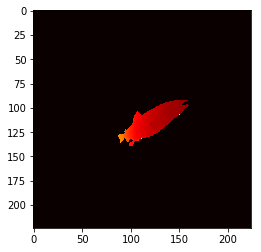

In [15]:
idx = 0
a= convert_to_scaled_rgb_image(np.load(segmentation_paths[idx]), 
                               np.load(depth_map_paths[idx]).T, 
                               json.load(open(annotation_paths[idx], 'rb')))
plt.imshow(a)

In [16]:
def generator(data_list, steps_per_epoch, BATCH_SIZE, INPUT_SHAPE):
    i = 0
    while True:
        x_batch = np.empty((BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        y_batch = np.empty((BATCH_SIZE, 1))
        for (ind, j) in enumerate(range(i*BATCH_SIZE, min((i+1)*BATCH_SIZE, len(data_list)))):
            segmentation_mask = np.load(data_list[j][0])
            depth_map = np.load(data_list[j][1]).T
            annotation = json.load(open(data_list[j][2], 'rb'))
            scaled_depth_map = convert_to_scaled_rgb_image(segmentation_mask, depth_map, annotation)
            
#             volume_class = get_volume_class_from_numeric_value(annotation['volume'])
            x_batch[ind, ...] = scaled_depth_map / 255.0
            y_batch[ind] = annotation['volume']
            
        i += 1
        if i >= steps_per_epoch:
            i = 0
        yield x_batch, y_batch

In [17]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=None, include_top=True)

#Add a layer where input is the output of the  second last layer 
x = Dense(1, name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
model = Model(input=vgg16.input, output=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
  


In [18]:
optimizer = keras.optimizers.adam(lr=0.0001, decay=0.1)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['accuracy'])

In [19]:
BATCH_SIZE = 25
steps_per_epoch = int(len(train_data_list)/BATCH_SIZE)
gen = generator(train_data_list, steps_per_epoch, BATCH_SIZE, (224, 224, 3))

In [20]:
model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=100, verbose=True)

Epoch 1/100
80/80 [==============================] - 226s 3s/step - loss: 1817.9600 - acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 167s 2s/step - loss: 1227.8991 - acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 167s 2s/step - loss: 965.5394 - acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 167s 2s/step - loss: 681.1551 - acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 167s 2s/step - loss: 483.7914 - acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 167s 2s/step - loss: 417.4607 - acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 167s 2s/step - loss: 393.1342 - acc: 0.0000e+00
Epoch 8/100
80/80 [==============================] - 167s 2s/step - loss: 377.9204 - acc: 0.0000e+00
Epoch 9/100
80/80 [==============================] - 167s 2s/step - loss: 367.5664 - acc: 0.0000e+00
Epoch 10/100
80/80 [==============================] - 168s 2s/step - loss: 360.6414 - acc

In [1]:
eval_gen = generator(test_data_list, steps_per_epoch, BATCH_SIZE, (224, 224, 3))
scores = model.evaluate_generator(eval_gen, 30)

NameError: name 'generator' is not defined

In [22]:
scores

[345.81402587890625, 0.0]

In [29]:
eval_gen = generator(test_data_list, steps_per_epoch, BATCH_SIZE, (224, 224, 3))
predictions = model.predict_generator(eval_gen, 120)

In [27]:
ground_truth_values = np.array([])
for i in range(100*25):
    annotation = json.load(open(test_data_list[i][2], 'rb'))
    ground_truth_values = np.append(ground_truth_values, annotation['volume'])

In [28]:
ground_truth_values

array([2068.00994581, 1983.57114122, 5667.58181159, 2049.77426155,
       1528.27865757, 1679.62820886, 1947.34439018,  684.62315282,
       2434.38040172, 5113.82745715, 8486.68708593, 7273.50315184,
       3423.50665138, 6234.69380593, 3862.53731828, 6785.19899183,
       3708.29718001, 7386.69905305, 5573.30013394, 5137.94349751,
       2104.43053116, 7616.8387957 , 4965.50153042, 1031.97936857,
        653.68714871,  795.52886466, 4588.47304829, 1055.92267465,
       2831.32756492, 2327.26298245, 3519.36642167, 8371.00638618,
       3409.9339579 , 2145.05276732,  641.34302622, 2712.55266872,
       7792.95574693, 2475.12041666,  411.3280957 , 2891.24525597,
        414.19034068, 1166.19174925,  415.51776598, 3304.26350106,
        764.68483052, 5550.34090059,  706.34773551, 2391.911852  ,
       1171.72532551,  862.73221058, 1208.00440943, 2103.96966803,
       3018.69930411, 1784.1289841 , 5950.56608098, 3310.11119381,
       5423.55895446, 4088.90170256, 8093.99164143, 2328.52493

In [56]:
predictions[:,0].mean()

3089.0618

In [30]:
(ground_truth_values.mean() - predictions[:,0].mean())/(ground_truth_values.mean())

0.032213283684685616